In [1]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt

import keras
from keras.layers import LeakyReLU, UpSampling1D, Input, Reshape, Activation, Lambda, AveragePooling1D
from keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.models import load_model
import random

# From pypng
import png
#from sklearn.p
import sklearn.metrics

FONTSIZE = 18
FIGURE_SIZE = (10,4)
FIGURE_SIZE2 = (10,10)

# Configure parameters
plt.rcParams.update({'font.size': FONTSIZE})

####################################
# 
import re

##################
# Default tick label size
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24



Using TensorFlow backend.


In [2]:
#Function for generating list of images of respective parts.
def make_df(file, coloumn_name, code, new_coloumn_entry):
    image_names = []
    check_for = file[coloumn_name] == code
    file_data = file[check_for]
    file_data['Lesion_typename'] = new_coloumn_entry
    return(file_data)

#Function for generating training, validation and test sets list of images of respective parts.
def sets(image_names):
    train_length = len(image_names) * 0.7
    int_train_length = int(train_length)
    val_length = int_train_length + len(image_names) * 0.15
    int_val_length = int(val_length)
    trainset = image_names[:int_train_length]
    valset = image_names[int_train_length:int_val_length]
    testset = image_names[int_val_length:]
    return (trainset, valset, testset)

#Function for generating lists of imagenames and labels for trainset, valset and testset.
def make_list(Full_list, data_length):
    image_name = []
    image_label = []
    #Storing annotated image file names in a list (image_name).
    for i in range (data_length):
        image_name.append(Full_list['File_name'].values[i])
    #Storing annotated image label names in a list (image_label).
    for i in range (data_length):
        image_label.append(Full_list['Coarse_lesion_type'].values[i])
    return (image_name, image_label)

#Function for reading each image file and returning a 3-dimensional array.
def Read_image(image_name):
    read_image = png.Reader(image_name)
    image_copy = read_image.read()
    image_in_2d = np.vstack(map(np.uint8, image_copy[2]))
    image_in_3d = np.reshape(image_in_2d, (image_copy[0],image_copy[1],image_copy[3]['planes'])) / 512.0
    return image_in_3d

#Function for reading each image file from given directory using given image name list and returning a array.
def Image_directory(directory, image_name):
    print(directory, image_name)
    #Get all of the file names
    all_images = sorted(os.listdir(directory))
    list_of_images = [Read_image(directory + "/" + i) for i in all_images if re.search(image_name, i) ]    
    return np.array(list_of_images, dtype=np.float32)



In [3]:
#Function which takes measurement coordinates from csv file and compute mid-point of bounding box and height and width
def target_point(Measurement_coordinates):
    split_Mesur_list = []
    x_pt = []
    y_pt = []
    
    split_Mesur_list = Measurement_coordinates.split(', ')
    x_ind = [0, 2, 4, 6]
    y_ind = [1, 3, 5, 7]
    
    #List for respective coordinate points.
    for i in x_ind:
        x_pt.append(float(split_Mesur_list[i]))
    for j in y_ind:
        y_pt.append(float(split_Mesur_list[j]))
    
    #Height and width of bounding box
    height = max(y_pt) - min(y_pt)
    width = max(x_pt) - min(x_pt)
    
    #Mid point estimation.
    x_mid_1 = (x_pt[0] + x_pt[1])/2
    y_mid_1 = (y_pt[0] + y_pt[1])/2
    x_mid_2 = (x_pt[2] + x_pt[3])/2
    y_mid_2 = (y_pt[2] + y_pt[3])/2
    x_mid = (x_mid_1 + x_mid_2)/2
    y_mid = (y_mid_1 + y_mid_2)/2
    
    return x_mid, y_mid, height, width

#Function which takes measurement coordinates and grid size in number of pixels and returns target label of respective shape.
def gen_target(Measurement_coordinates, grid_size = 16):
    #Computing mid point, height and width of bounding box.
    x_mid, y_mid, height, width = target_point(Measurement_coordinates)
    #Total number of grids, using given grid size.
    grids = int(512/grid_size)
    
    #Locating grid which has midpoint.
    x_grid = int(x_mid/grid_size)
    y_grid = int(y_mid/grid_size)

    #mid points with respect to each grid
    x_mid_grid = (x_mid/grid_size) - x_grid
    y_mid_grid = (y_mid/grid_size) - y_grid
    
    #initializing target label as all zeros.
    target = np.zeros((grids,grids,5))
    #Defining and filling up list with "Pc", "bx", "by", "bh", and "bw"
    coord_list = []
    coord_list.append(1)
    coord_list.append(x_mid_grid)
    coord_list.append(y_mid_grid)
    coord_list.append(height)
    coord_list.append(width)
    
    #mid point located grid is filled with the above information.
    for i in range(len(coord_list)):
        target[x_grid][y_grid][i] = coord_list[i]
    
    return target

#Function for generating target labels for trainset, valset and testset.
def make_yolo(inlist, grid_size):
    image_name = []
    yolo_label = []
    data_length = inlist.shape[0]
    #Storing annotated image file names in a list (image_name).
    for i in range (data_length):
        image_name.append(inlist['File_name'].values[i])
    #Storing annotated image label names in a list (image_label).
    for i in range (data_length):
        Measurement_coordinates = inlist['Measurement_coordinates'].values[i]
        yolo_label.append(gen_target(Measurement_coordinates, grid_size))
    return (image_name, yolo_label)


In [4]:
#Reading file with file name and labels.

#Storing the images in directory.
directory = '/home2/potd0000/project/Key_slices/'

#data information extraction from csv file
Entire_image_list = pd.read_csv(r'/home2/potd0000/project/Dl_info.csv')
#Removing all other coloumns and only selecting Filename, Coarse_lesion_type and, Image_size to be there in dataframe.
list_filename_n_type = Entire_image_list[['File_name', 'Coarse_lesion_type', 'Image_size', 'Measurement_coordinates', 'Bounding_boxes', 'Lesion_diameters_Pixel_', 'Normalized_lesion_location']]

#Eliminating 40 image names which is not of size '512 x 512'
check_for_size = list_filename_n_type['Image_size'] == '512, 512'
list_filename_n_type = list_filename_n_type[check_for_size]

#Creating dataframes for each body parts.
Bone_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 1, 'Bone')
Abdomen_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 2, 'Abdomen')
Mediastinum_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 3, 'Mediastinum')
Liver_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 4, 'Liver')
Lung_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 5, 'Lung')
Kidney_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 6, 'Kidney')
Soft_tissue_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 7, 'Soft_tissue')
Pelvis_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 8, 'Pelvis')

#Creating train, validation and test sets.
trainset_Bone, valset_Bone, testset_Bone = sets(Bone_image_names)
trainset_Abdomen, valset_Abdomen, testset_Abdomen = sets(Abdomen_image_names)
trainset_Mediastinum, valset_Mediastinum, testset_Mediastinum = sets(Mediastinum_image_names)
trainset_Liver, valset_Liver, testset_Liver = sets(Liver_image_names)
trainset_Lung, valset_Lung, testset_Lung = sets(Lung_image_names)
trainset_Kidney, valset_Kidney, testset_Kidney = sets(Kidney_image_names)
trainset_Soft_tissue, valset_Soft_tissue, testset_Soft_tissue = sets(Soft_tissue_image_names)
trainset_Pelvis, valset_Pelvis, testset_Pelvis = sets(Pelvis_image_names)



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
#Creating yolo label and respective image name list.
yolo_train_lung_ins, yolo_train_lung_outs = make_yolo(trainset_Lung, 32)
yolo_val_lung_ins, yolo_val_lung_outs = make_yolo(valset_Lung, 32)
yolo_test_lung_ins, yolo_test_lung_outs = make_yolo(testset_Lung, 32)

yolo_train_mediastinum_ins, yolo_train_mediastinum_outs = make_yolo(trainset_Mediastinum, 32)
yolo_val_mediastinum_ins, yolo_val_mediastinum_outs = make_yolo(valset_Mediastinum, 32)
yolo_test_mediastinum_ins, yolo_test_mediastinum_outs = make_yolo(testset_Mediastinum, 32)

yolo_train_abdomen_ins, yolo_train_abdomen_outs = make_yolo(trainset_Abdomen, 32)
yolo_val_abdomen_ins, yolo_val_abdomen_outs = make_yolo(valset_Abdomen, 32)
yolo_test_abdomen_ins, yolo_test_abdomen_outs = make_yolo(testset_Abdomen, 32)

yolo_train_liver_ins, yolo_train_liver_outs = make_yolo(trainset_Liver, 32)
yolo_val_liver_ins, yolo_val_liver_outs = make_yolo(valset_Liver, 32)
yolo_test_liver_ins, yolo_test_liver_outs = make_yolo(testset_Liver, 32)

yolo_train_kidney_ins, yolo_train_kidney_outs = make_yolo(trainset_Kidney, 32)
yolo_val_kidney_ins, yolo_val_kidney_outs = make_yolo(valset_Kidney, 32)
yolo_test_kidney_ins, yolo_test_kidney_outs = make_yolo(testset_Kidney, 32)

yolo_train_bone_ins, yolo_train_bone_outs = make_yolo(trainset_Bone, 32)
yolo_val_bone_ins, yolo_val_bone_outs = make_yolo(valset_Bone, 32)
yolo_test_bone_ins, yolo_test_bone_outs = make_yolo(testset_Bone, 32)


In [ ]:
#Train Data for Lungs
train_image_data_lung_list = []
for names in yolo_train_lung_ins:
    train_image_data_lung_list.extend(Image_directory(directory, names))
input_train_image_lung = np.array(train_image_data_lung_list)
input_train_image_lung.shape


/home2/potd0000/project/Key_slices/ 000004_02_02_073.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 000004_02_02_145.png
/home2/potd0000/project/Key_slices/ 000004_03_02_136.png
/home2/potd0000/project/Key_slices/ 000009_04_02_022.png
/home2/potd0000/project/Key_slices/ 000009_04_03_101.png
/home2/potd0000/project/Key_slices/ 000013_01_01_044.png
/home2/potd0000/project/Key_slices/ 000020_03_01_134.png
/home2/potd0000/project/Key_slices/ 000020_03_01_212.png
/home2/potd0000/project/Key_slices/ 000020_03_01_166.png
/home2/potd0000/project/Key_slices/ 000020_04_01_159.png
/home2/potd0000/project/Key_slices/ 000020_04_01_116.png
/home2/potd0000/project/Key_slices/ 000020_04_01_143.png
/home2/potd0000/project/Key_slices/ 000026_06_01_165.png
/home2/potd0000/project/Key_slices/ 000026_06_01_257.png
/home2/potd0000/project/Key_slices/ 000027_03_01_095.png
/home2/potd0000/project/Key_slices/ 000027_04_01_119.png
/home2/potd0000/project/Key_slices/ 000027_05_01_099.png
/home2/potd0000/project/Key_slices/ 000027_06_01_020.png
/home2/potd0000/project/Key_sli

In [ ]:
#Validation Data for Lungs
val_image_data_lung_list = []
for names in yolo_val_lung_ins:
    val_image_data_lung_list.extend(Image_directory(directory, names))
input_val_image_lung = np.array(val_image_data_lung_list)
input_val_image_lung.shape

In [6]:
#Test Data for Lungs
test_image_data_lung_list = []
for names in yolo_test_lung_ins:
    test_image_data_lung_list.extend(Image_directory(directory, names))
input_test_image_lung = np.array(test_image_data_lung_list)
input_test_image_lung.shape

/home2/potd0000/project/Key_slices/ 003580_11_01_148.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 003580_11_01_109.png
/home2/potd0000/project/Key_slices/ 003580_12_01_186.png
/home2/potd0000/project/Key_slices/ 003580_12_01_192.png
/home2/potd0000/project/Key_slices/ 003581_01_01_047.png
/home2/potd0000/project/Key_slices/ 003581_01_03_199.png
/home2/potd0000/project/Key_slices/ 003599_01_02_232.png
/home2/potd0000/project/Key_slices/ 003599_03_02_252.png
/home2/potd0000/project/Key_slices/ 003602_01_02_490.png
/home2/potd0000/project/Key_slices/ 003602_01_02_280.png
/home2/potd0000/project/Key_slices/ 003602_01_02_874.png
/home2/potd0000/project/Key_slices/ 003612_01_01_177.png
/home2/potd0000/project/Key_slices/ 003612_02_01_174.png
/home2/potd0000/project/Key_slices/ 003613_01_02_105.png
/home2/potd0000/project/Key_slices/ 003616_01_01_259.png
/home2/potd0000/project/Key_slices/ 003634_01_02_170.png
/home2/potd0000/project/Key_slices/ 003635_01_01_191.png
/home2/potd0000/project/Key_slices/ 003635_01_01_103.png
/home2/potd0000/project/Key_sli

(359, 512, 512, 3)

In [7]:
#Renaming for avoiding confusion!
#ins_train_lung = input_train_image_lung
#outs_train_lung = np.array(yolo_train_lung_outs)
#ins_validation_lung = input_val_image_lung
#outs_validation_lung = np.array(yolo_val_lung_outs)
ins_test_lung = input_test_image_lung
outs_test_lung = np.array(yolo_test_lung_outs)

In [6]:
#Train Data for mediastinum
train_image_data_mediastinum_list = []
for names in yolo_train_mediastinum_ins:
    train_image_data_mediastinum_list.extend(Image_directory(directory, names))
input_train_image_mediastinum = np.array(train_image_data_mediastinum_list)
input_train_image_mediastinum.shape


/home2/potd0000/project/Key_slices/ 000001_01_01_109.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 000001_02_01_014.png
/home2/potd0000/project/Key_slices/ 000001_02_01_017.png
/home2/potd0000/project/Key_slices/ 000001_03_01_088.png
/home2/potd0000/project/Key_slices/ 000001_04_01_017.png
/home2/potd0000/project/Key_slices/ 000021_01_01_016.png
/home2/potd0000/project/Key_slices/ 000021_02_01_068.png
/home2/potd0000/project/Key_slices/ 000021_03_01_012.png
/home2/potd0000/project/Key_slices/ 000021_03_01_017.png
/home2/potd0000/project/Key_slices/ 000021_04_01_090.png
/home2/potd0000/project/Key_slices/ 000040_05_02_122.png
/home2/potd0000/project/Key_slices/ 000047_01_01_002.png
/home2/potd0000/project/Key_slices/ 000047_02_01_004.png
/home2/potd0000/project/Key_slices/ 000052_02_01_026.png
/home2/potd0000/project/Key_slices/ 000052_03_01_026.png
/home2/potd0000/project/Key_slices/ 000053_06_01_231.png
/home2/potd0000/project/Key_slices/ 000068_01_01_008.png
/home2/potd0000/project/Key_slices/ 000068_02_01_011.png
/home2/potd0000/project/Key_sli

(1170, 512, 512, 3)

In [7]:
#Validation Data for mediastinum
val_image_data_mediastinum_list = []
for names in yolo_val_mediastinum_ins:
    val_image_data_mediastinum_list.extend(Image_directory(directory, names))
input_val_image_mediastinum = np.array(val_image_data_mediastinum_list)
input_val_image_mediastinum.shape

/home2/potd0000/project/Key_slices/ 002818_01_01_055.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 002823_01_01_090.png
/home2/potd0000/project/Key_slices/ 002824_02_01_144.png
/home2/potd0000/project/Key_slices/ 002824_02_01_144.png
/home2/potd0000/project/Key_slices/ 002824_02_01_144.png
/home2/potd0000/project/Key_slices/ 002824_03_01_153.png
/home2/potd0000/project/Key_slices/ 002832_01_01_025.png
/home2/potd0000/project/Key_slices/ 002837_01_01_182.png
/home2/potd0000/project/Key_slices/ 002840_01_01_027.png
/home2/potd0000/project/Key_slices/ 002840_02_01_023.png
/home2/potd0000/project/Key_slices/ 002842_01_01_016.png
/home2/potd0000/project/Key_slices/ 002842_01_01_023.png
/home2/potd0000/project/Key_slices/ 002842_01_01_021.png
/home2/potd0000/project/Key_slices/ 002842_02_01_021.png
/home2/potd0000/project/Key_slices/ 002842_02_01_023.png
/home2/potd0000/project/Key_slices/ 002842_02_01_016.png
/home2/potd0000/project/Key_slices/ 002842_03_01_025.png
/home2/potd0000/project/Key_slices/ 002842_04_01_026.png
/home2/potd0000/project/Key_sli

(250, 512, 512, 3)

In [8]:
#Test Data for mediastinum
test_image_data_mediastinum_list = []
for names in yolo_test_mediastinum_ins:
    test_image_data_mediastinum_list.extend(Image_directory(directory, names))
input_test_image_mediastinum = np.array(test_image_data_mediastinum_list)
input_test_image_mediastinum.shape

/home2/potd0000/project/Key_slices/ 003557_01_01_059.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 003557_03_01_278.png
/home2/potd0000/project/Key_slices/ 003561_01_01_025.png
/home2/potd0000/project/Key_slices/ 003561_01_01_014.png
/home2/potd0000/project/Key_slices/ 003563_01_01_016.png
/home2/potd0000/project/Key_slices/ 003564_01_01_075.png
/home2/potd0000/project/Key_slices/ 003564_01_01_118.png
/home2/potd0000/project/Key_slices/ 003564_01_01_098.png
/home2/potd0000/project/Key_slices/ 003564_01_01_130.png
/home2/potd0000/project/Key_slices/ 003564_02_01_118.png
/home2/potd0000/project/Key_slices/ 003564_02_01_073.png
/home2/potd0000/project/Key_slices/ 003565_01_01_023.png
/home2/potd0000/project/Key_slices/ 003565_01_01_027.png
/home2/potd0000/project/Key_slices/ 003565_01_01_027.png
/home2/potd0000/project/Key_slices/ 003565_02_01_024.png
/home2/potd0000/project/Key_slices/ 003571_01_01_044.png
/home2/potd0000/project/Key_slices/ 003574_02_01_018.png
/home2/potd0000/project/Key_slices/ 003574_02_01_009.png
/home2/potd0000/project/Key_sli

(252, 512, 512, 3)

In [9]:
#Renaming for avoiding confusion!
ins_train_mediastinum = input_train_image_mediastinum
outs_train_mediastinum = np.array(yolo_train_mediastinum_outs)
ins_validation_mediastinum = input_val_image_mediastinum
outs_validation_mediastinum = np.array(yolo_val_mediastinum_outs)
ins_test_mediastinum = input_test_image_mediastinum
outs_test_mediastinum = np.array(yolo_test_mediastinum_outs)

In [ ]:
#Train Data for abdomen
train_image_data_abdomen_list = []
for names in yolo_train_abdomen_ins:
    train_image_data_abdomen_list.extend(Image_directory(directory, names))
input_train_image_abdomen = np.array(train_image_data_abdomen_list)
input_train_image_abdomen.shape

In [ ]:
#Validation Data for abdomen
val_image_data_abdomen_list = []
for names in yolo_val_abdomen_ins:
    val_image_data_abdomen_list.extend(Image_directory(directory, names))
input_val_image_abdomen = np.array(val_image_data_abdomen_list)
input_val_image_abdomen.shape

In [ ]:
#Test Data for abdomen
test_image_data_abdomen_list = []
for names in yolo_test_abdomen_ins:
    test_image_data_abdomen_list.extend(Image_directory(directory, names))
input_test_image_abdomen = np.array(test_image_data_abdomen_list)
input_test_image_abdomen.shape

In [ ]:
#Renaming for avoiding confusion!
ins_train_abdomen = input_train_image_abdomen
outs_train_abdomen = np.array(yolo_train_abdomen_outs)
ins_validation_abdomen = input_val_image_abdomen
outs_validation_abdomen = np.array(yolo_val_abdomen_outs)
ins_test_abdomen = input_test_image_abdomen
outs_test_abdomen = np.array(yolo_test_abdomen_outs)

In [19]:
#Train Data for kidney
train_image_data_kidney_list = []
for names in yolo_train_kidney_ins:
    train_image_data_kidney_list.extend(Image_directory(directory, names))
input_train_image_kidney = np.array(train_image_data_kidney_list)
input_train_image_kidney.shape

/home2/potd0000/project/Key_slices/ 000010_01_01_084.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 000016_01_01_030.png
/home2/potd0000/project/Key_slices/ 000016_01_01_030.png
/home2/potd0000/project/Key_slices/ 000016_01_01_025.png
/home2/potd0000/project/Key_slices/ 000016_02_01_333.png
/home2/potd0000/project/Key_slices/ 000016_02_01_358.png
/home2/potd0000/project/Key_slices/ 000016_02_01_346.png
/home2/potd0000/project/Key_slices/ 000022_02_02_066.png
/home2/potd0000/project/Key_slices/ 000022_03_01_063.png
/home2/potd0000/project/Key_slices/ 000026_01_01_076.png
/home2/potd0000/project/Key_slices/ 000026_02_01_078.png
/home2/potd0000/project/Key_slices/ 000026_02_01_079.png
/home2/potd0000/project/Key_slices/ 000026_03_01_074.png
/home2/potd0000/project/Key_slices/ 000026_03_01_073.png
/home2/potd0000/project/Key_slices/ 000026_03_01_077.png
/home2/potd0000/project/Key_slices/ 000026_03_01_075.png
/home2/potd0000/project/Key_slices/ 000026_04_01_339.png
/home2/potd0000/project/Key_slices/ 000026_04_01_361.png
/home2/potd0000/project/Key_sli

(346, 512, 512, 3)

In [20]:
#Validation Data for kidney
val_image_data_kidney_list = []
for names in yolo_val_kidney_ins:
    val_image_data_kidney_list.extend(Image_directory(directory, names))
input_val_image_kidney = np.array(val_image_data_kidney_list)
input_val_image_kidney.shape

/home2/potd0000/project/Key_slices/ 003006_02_02_063.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 003006_02_02_076.png
/home2/potd0000/project/Key_slices/ 003006_02_02_059.png
/home2/potd0000/project/Key_slices/ 003015_01_01_068.png
/home2/potd0000/project/Key_slices/ 003015_02_01_071.png
/home2/potd0000/project/Key_slices/ 003015_02_01_074.png
/home2/potd0000/project/Key_slices/ 003018_04_01_076.png
/home2/potd0000/project/Key_slices/ 003054_01_01_066.png
/home2/potd0000/project/Key_slices/ 003054_01_01_069.png
/home2/potd0000/project/Key_slices/ 003054_01_01_064.png
/home2/potd0000/project/Key_slices/ 003071_01_01_035.png
/home2/potd0000/project/Key_slices/ 003071_02_01_067.png
/home2/potd0000/project/Key_slices/ 003078_01_01_059.png
/home2/potd0000/project/Key_slices/ 003118_01_01_437.png
/home2/potd0000/project/Key_slices/ 003122_01_01_299.png
/home2/potd0000/project/Key_slices/ 003122_01_01_298.png
/home2/potd0000/project/Key_slices/ 003122_02_01_301.png
/home2/potd0000/project/Key_slices/ 003144_01_01_060.png
/home2/potd0000/project/Key_sli

(74, 512, 512, 3)

In [21]:
#Test Data for kidney
test_image_data_kidney_list = []
for names in yolo_test_kidney_ins:
    test_image_data_kidney_list.extend(Image_directory(directory, names))
input_test_image_kidney = np.array(test_image_data_kidney_list)
input_test_image_kidney.shape

/home2/potd0000/project/Key_slices/ 003599_01_01_407.png


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/home2/potd0000/project/Key_slices/ 003599_03_01_359.png
/home2/potd0000/project/Key_slices/ 003599_03_01_431.png
/home2/potd0000/project/Key_slices/ 003620_01_01_148.png
/home2/potd0000/project/Key_slices/ 003620_01_01_187.png
/home2/potd0000/project/Key_slices/ 003620_01_01_164.png
/home2/potd0000/project/Key_slices/ 003622_01_01_207.png
/home2/potd0000/project/Key_slices/ 003634_01_01_064.png
/home2/potd0000/project/Key_slices/ 003653_01_01_254.png
/home2/potd0000/project/Key_slices/ 003663_01_02_061.png
/home2/potd0000/project/Key_slices/ 003663_01_02_060.png
/home2/potd0000/project/Key_slices/ 003663_01_02_082.png
/home2/potd0000/project/Key_slices/ 003663_02_02_343.png
/home2/potd0000/project/Key_slices/ 003663_02_02_439.png
/home2/potd0000/project/Key_slices/ 003674_01_01_378.png
/home2/potd0000/project/Key_slices/ 003687_01_01_048.png
/home2/potd0000/project/Key_slices/ 003693_01_03_065.png
/home2/potd0000/project/Key_slices/ 003698_01_01_071.png
/home2/potd0000/project/Key_sli

(75, 512, 512, 3)

In [22]:
#Renaming for avoiding confusion!
ins_train_kidney = input_train_image_kidney
outs_train_kidney = np.array(yolo_train_kidney_outs)
ins_validation_kidney = input_val_image_kidney
outs_validation_kidney = np.array(yolo_val_kidney_outs)
ins_test_kidney = input_test_image_kidney
outs_test_kidney = np.array(yolo_test_kidney_outs)

In [ ]:
#Train Data for liver
train_image_data_liver_list = []
for names in yolo_train_liver_ins:
    train_image_data_liver_list.extend(Image_directory(directory, names))
input_train_image_liver = np.array(train_image_data_liver_list)
input_train_image_liver.shape

In [ ]:
#Validation Data for liver
val_image_data_liver_list = []
for names in yolo_val_liver_ins:
    val_image_data_liver_list.extend(Image_directory(directory, names))
input_val_image_liver = np.array(val_image_data_liver_list)
input_val_image_liver.shape

In [ ]:
#Test Data for liver
test_image_data_liver_list = []
for names in yolo_test_liver_ins:
    test_image_data_liver_list.extend(Image_directory(directory, names))
input_test_image_liver = np.array(test_image_data_liver_list)
input_test_image_liver.shape

In [ ]:
#Renaming for avoiding confusion!
ins_train_liver = input_train_image_liver
outs_train_liver = np.array(yolo_train_liver_outs)
ins_validation_liver = input_val_image_liver
outs_validation_liver = np.array(yolo_val_liver_outs)
ins_test_liver = input_test_image_liver
outs_test_liver = np.array(yolo_test_liver_outs)

In [23]:
#Constructing Network

#we are using three 2D convolution layers each with 100, 200, 300, 400, 500, 600, 700, 800 filters.
#we are using 2D transpose convolution layers with 600, 300, 100, 50, 10 filters.
#For final output we are using 2D convolution layer with 5 filters.
#I am using regularization with value 0
#To bring down the number of parameters, I am using 1 x 1 strides in two Maxpooling layers.

def construct_model(input_shape, lambda_regularization = 0):
    model = Sequential()
    
    model.add(Convolution2D(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C0'))
    
    model.add(Convolution2D(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C1'))
    
    model.add(Convolution2D(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C2'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C3'))
    
    model.add(Convolution2D(filters = 20,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C4'))
    
    model.add(Convolution2D(filters = 20,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C5'))

    model.add(Convolution2D(filters = 20,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C6'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C7'))

    model.add(Convolution2D(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C8'))

    model.add(Convolution2D(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C9'))

    model.add(Convolution2D(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C10'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C11'))
    
    model.add(Convolution2D(filters = 40,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C12'))
    
    model.add(Convolution2D(filters = 40,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C13'))
    
    model.add(Convolution2D(filters = 40,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'elu',
                           name = 'C14'))
        
    model.add(Convolution2D(filters = 5,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'valid',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'sigmoid',
                           name = 'output'))
        
    
    # The optimizer determines how the gradient descent is to be done
    opt = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, 
                            epsilon = None, decay = 0.0, amsgrad = False)
    
    model.compile(loss = 'binary_crossentropy', optimizer = opt, 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [24]:
model_kidney = construct_model(ins_train_kidney.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C0 (Conv2D)                  (None, 255, 255, 10)      280       
_________________________________________________________________
C1 (Conv2D)                  (None, 251, 251, 10)      2510      
_________________________________________________________________
C2 (Conv2D)                  (None, 249, 249, 10)      910       
_________________________________________________________________
C3 (MaxPooling2D)            (None, 247, 247, 10)      0         
_________________________________________________________________
C4 (Conv2D)                  (None, 123, 123, 20)      1820      
_________________________________________________________________
C5 (Conv2D)                  (None, 119, 119, 20)      10020     
_________________________________________________________________
C6 (Conv2D)                  (None, 117, 117, 20)      3620      
__________

In [25]:
def training_set_generator(ins, outs, batch_size = 10,
                      input_name = 'input_input', 
                      output_name = 'output'):
    while True:
        example_indices = random.choices(range(ins.shape[0]), k=batch_size)
        yield({input_name: ins[example_indices,:,:,:]},
             {output_name: outs[example_indices]})


In [ ]:
generator = training_set_generator(ins_train_kidney, outs_train_kidney, batch_size = 20, 
                                  input_name = 'C0_input')

#Stopping criteria for epoch termination with patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                               min_delta = 0, patience = 10, 
                                               verbose = 0, mode = 'auto', 
                                               baseline = None, 
                                               restore_best_weights = True)

#Total training set has 1673 images and batch size is 100.
#Hence 18 steps per epoch will cover entire training dataset.
model_kidney.fit_generator(generator, epochs = 200, steps_per_epoch = 18, 
                    validation_data=(ins_validation_kidney, outs_validation_kidney))

Epoch 1/200
18/18 [==============================] - 75s 4s/step - loss: 0.6624 - acc: 0.8081 - val_loss: 0.6024 - val_acc: 0.9961
Epoch 2/200
18/18 [==============================] - 71s 4s/step - loss: 0.3995 - acc: 0.9961 - val_loss: 0.1645 - val_acc: 0.9961
Epoch 3/200
18/18 [==============================] - 69s 4s/step - loss: 0.1455 - acc: 0.9961 - val_loss: 0.1546 - val_acc: 0.9961
Epoch 4/200
18/18 [==============================] - 70s 4s/step - loss: 0.1409 - acc: 0.9961 - val_loss: 0.1502 - val_acc: 0.9961
Epoch 5/200
18/18 [==============================] - 70s 4s/step - loss: 0.1360 - acc: 0.9961 - val_loss: 0.1511 - val_acc: 0.9961
Epoch 6/200
18/18 [==============================] - 70s 4s/step - loss: 0.1381 - acc: 0.9961 - val_loss: 0.1502 - val_acc: 0.9961
Epoch 7/200
18/18 [==============================] - 70s 4s/step - loss: 0.1326 - acc: 0.9961 - val_loss: 0.1508 - val_acc: 0.9961
Epoch 8/200
18/18 [==============================] - 71s 4s/step - loss: 0.1395 - a

In [ ]:
model_kidney.save('lesion_detection_kidney_model-3.h5')

In [9]:
model_lung = keras.models.load_model('yolo_model_bhairav-3.h5')

In [25]:
pred_lung = model_lung.predict(ins_test_lung)

In [10]:
model_mediastinum = keras.models.load_model('lesion_detection_mediastinum_model.h5')

In [11]:
pred_mediastinum = model_mediastinum.predict(ins_test_mediastinum)

In [ ]:
model_kidney = keras.models.load_model('lesion_detection_kidney_model.h5')

In [ ]:
pred_mediastinum = model_mediastinum.predict(ins_test_mediastinum)

In [10]:
def max_from_out(x, grids = 16):
    new_x = np.zeros((grids, grids))
    for i in range (grids):
        for j in range (grids):
            new_x[i][j] = x[i][j][0]
    max_pos = np.where(new_x == np.amax(new_x))
    #print("Maximum Probability is: ", np.amax(new_x))
    return max_pos

def just_one(x, grids = 16):
    new = np.zeros((grids, grids))
    for i in range (grids):
        for j in range (grids):
            new[i][j] = x[i][j][0]
    return new

#Function for finding true and false positives.
#ins_test: Here give input of dataset on which you have predicted the predictions.
#pred: The predictions predicted on ins_test
#buff: It is padding or range of buffer for True Positives. This is because, model is not perfectly accurate.

def confusion_matrix(model, ins, outs, buff = 5):
    True_Positive = 0
    False_Positive = 0
    pred = model.predict(ins)
    for i in range (len(ins)):
        predicted_pos = max_from_out(pred[i], 16)
        predicted_x = predicted_pos[0]
        predicted_y = predicted_pos[1]
        actual_pos = max_from_out(outs[i], 16)
        actual_x = actual_pos[0]
        actual_y = actual_pos[1]
        if (predicted_x in range (int(actual_x - buff), int(actual_x + buff))):
            if (predicted_y in range (int(actual_y - buff), int(actual_y + buff))):
                True_Positive = True_Positive + 1
            else:
                False_Positive = False_Positive + 1
        else:
            False_Positive = False_Positive + 1

    return(True_Positive, False_Positive)        



def ROC(model, ins, outs, ins_val, outs_val, buff = 5):

    True_Positive, False_Positive = confusion_matrix(model, ins, outs, buff = buff)
    tpr = True_Positive/len(ins)
    fpr = False_Positive/False_Positive    
    #auc = sklearn.metrics.auc(fpr, tpr)
    
    True_Positive_val, False_Positive_val = confusion_matrix(model, ins_val, outs_val, buff = buff)
    tpr_val = True_Positive/len(ins_val)
    fpr_val = False_Positive/False_Positive    
    #auc_val = sklearn.metrics.auc(fpr_val, tpr_val)
    
    # Generate the plot
    plt.figure(1)
    plt.axis('equal')
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, 'b')#, label='Train AUC = {:.3f}'.format(auc))
    plt.plot(fpr_val, tpr_val, 'r')#, label='Validation AUC = {:.3f}'.format(auc_val))
    plt.legend(loc='best')
    plt.xlabel('FPR', fontsize=FONTSIZE)
    plt.ylabel('TPR', fontsize=FONTSIZE)

In [22]:
def Act_ROC(model, ins, outs):
    vec = []
    #act = []
    pred = model.predict(ins)
    for i in range (len(outs)):
        loc = []
        #outs_new = just_one(outs[i], grids = 16)
        #act[i] = np.amax(outs_new)
        act = np.ones(len(outs_test_lung))
        loc = max_from_out(outs, grids = 16)
        vec[i] = pred[int(loc[0])][int(loc[1])]
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(act, vec)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    # Generate the plot
    plt.figure(1)
    plt.axis('equal')
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, 'b', label='Train AUC = {:.3f}'.format(auc))
#    plt.plot(fpr_val, tpr_val, 'r')#, label='Validation AUC = {:.3f}'.format(auc_val))
    plt.legend(loc='best')
    plt.xlabel('FPR', fontsize=FONTSIZE)
    plt.ylabel('TPR', fontsize=FONTSIZE)

In [24]:
Act_ROC(model_lung, ins_test_lung[:10], outs_test_lung[:10])
pred = model.predict(ins)
for i in range (len(outs)):
    loc = []
    #outs_new = just_one(outs[i], grids = 16)
    #act[i] = np.amax(outs_new)
    act = np.ones(len(outs_test_lung))
    loc = max_from_out(outs, grids = 16)
    vec[i] = pred[int(loc[0])][int(loc[1])]
    
fpr, tpr, thresholds = sklearn.metrics.roc_curve(act, vec)
auc = sklearn.metrics.auc(fpr, tpr)
    
    # Generate the plot
plt.figure(1)
plt.axis('equal')
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, 'b', label='Train AUC = {:.3f}'.format(auc))
#    plt.plot(fpr_val, tpr_val, 'r')#, label='Validation AUC = {:.3f}'.format(auc_val))
plt.legend(loc='best')
plt.xlabel('FPR', fontsize=FONTSIZE)
plt.ylabel('TPR', fontsize=FONTSIZE)

ValueError: setting an array element with a sequence.

In [22]:
new_x = np.zeros((16, 16))
for i in range (16):
    for j in range (16):
        new_x[i][j] = pred_mediastinum[5][i][j][0]
    max_pos = np.where(new_x == np.amax(new_x))
print("Maximum Probability is: ", np.amax(new_x))
#return max_pos

Maximum Probability is:  0.11081764847040176


Predicted Position:  (array([9]), array([4]))
Actual Position:  (array([12]), array([7]))


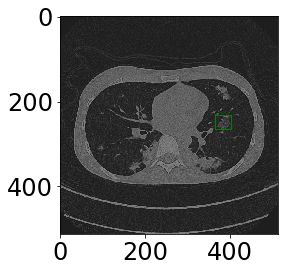

In [138]:
i = 0
predicted_pos = max_from_out(pred_lung[i], 16)
actual_pos = max_from_out(outs_test_lung[i], 16)
print("Predicted Position: ", predicted_pos)
print("Actual Position: ", actual_pos)
plt.imshow(ins_test_lung[i])

In [131]:
pred_lung[0].shape

(16, 16, 5)

Predicted Position:  (array([10]), array([10]))
Actual Position:  (array([11]), array([10]))
10 10 320 320


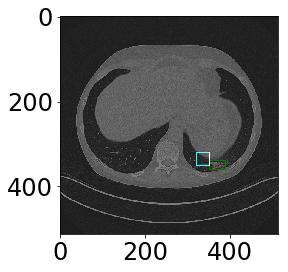

In [152]:
i = 14
predicted_pos = max_from_out(pred_lung[i], 16)
actual_pos = max_from_out(outs_test_lung[i], 16)
print("Predicted Position: ", predicted_pos)
print("Actual Position: ", actual_pos)
plt.imshow(ins_test_lung[i])
pred = ins_test_lung[i]
pred_lung
predicted_pos = max_from_out(pred_lung[i], 16)
predicted_pos1 = int(predicted_pos[0])
predicted_pos2 = int(predicted_pos[1])
pix1 = predicted_pos2 * 32
pix2 = predicted_pos1 * 32
print(predicted_pos1, predicted_pos2, pix1, pix2)
new_ins1 = pred
for j in range (32):
    new_ins1[pix1 + 0][pix2 + j][2] = 1
for j in range (32):
    new_ins1[pix1 + 31][pix2 + j][2] = 1
for i in range (32):
    new_ins1[pix1 + i][pix2 + 0][2] = 1
for i in range (32):
    new_ins1[pix1 + i][pix2 + 31][2] = 1
plt.imshow(new_ins1)

In [137]:
ins_test_lung[0].shape

(512, 512, 3)

In [104]:
new_ins1 = ins_test_lung[14]
for i in range (0):
    for j in range (32):
        new_ins1[288 + i][192 + j][1] = 1.0

In [133]:
def box(ins, grid_size = 32, color = 'b', intensity = 1.0):
    predicted_pos = max_from_out(ins)
    predicted_pos1 = int(predicted_pos[0])
    predicted_pos2 = int(predicted_pos[1])
    pix1 = predicted_pos2 * grid_size
    pix2 = predicted_pos1 * grid_size

    if color == 'g':
        c = 0
    elif color == 'y':
        c = 1
    elif color == 'b':
        c = 2
    
    new_ins1 = ins
    for j in range (grid_size):
        new_ins1[pix1 + 0][pix2 + j][c] = intensity
    for j in range (grid_size):
        new_ins1[pix1 + grid_size - 1][pix2 + j][c] = intensity
    for i in range (grid_size):
        new_ins1[pix1 + i][pix2 + 0][c] = intensity
    for i in range (grid_size):
        new_ins1[pix1 + i][pix2 + grid_size - 1][c] = intensity
    plt.imshow(new_ins1)

In [134]:
box(ins_test_lung[0], grid_size = 32, color = 'b', intensity = 1.0)

TypeError: only size-1 arrays can be converted to Python scalars

In [20]:
confusion_matrix(model_mediastinum, ins_test_mediastinum, outs_test_mediastinum, buff = 3)

(199, 53)

In [ ]:
confusion_matrix(model_lung, ins_train_lung, outs_train_lung, buff = 5)

Maximum Probability is:  0.18470486998558044
Maximum Probability is:  1.0
Maximum Probability is:  0.1404167115688324
Maximum Probability is:  1.0
Maximum Probability is:  0.11812188476324081
Maximum Probability is:  1.0
Maximum Probability is:  0.165694922208786
Maximum Probability is:  1.0
Maximum Probability is:  0.17120683193206787
Maximum Probability is:  1.0
Maximum Probability is:  0.11081764847040176
Maximum Probability is:  1.0
Maximum Probability is:  0.0766286551952362
Maximum Probability is:  1.0
Maximum Probability is:  0.09124597907066345
Maximum Probability is:  1.0
Maximum Probability is:  0.13698121905326843
Maximum Probability is:  1.0
Maximum Probability is:  0.08753330260515213
Maximum Probability is:  1.0
Maximum Probability is:  0.1510312408208847
Maximum Probability is:  1.0
Maximum Probability is:  0.1497466266155243
Maximum Probability is:  1.0
Maximum Probability is:  0.13467782735824585
Maximum Probability is:  1.0
Maximum Probability is:  0.13467782735824585

No handles with labels found to put in legend.


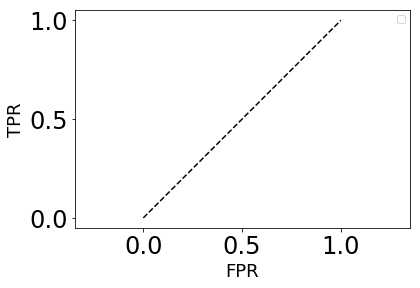

In [13]:
ROC(model_mediastinum, ins_test_mediastinum, outs_test_mediastinum, ins_validation_mediastinum, outs_validation_mediastinum, buff = 5)

In [29]:
def intermediate_model_state(model, ins, layer_list):
    '''
    Return layer activations for intermediate layers in a model for a set of examples
    
    :param model: Model in question
    :param ins: Input tensor (examples, rows, cols, channels)
    :param layer_list: List of layer names to produce activations for
    :returns: a list of numpy arrays
    '''
    # Translate layer names into corresponding output tensors
    layer_outputs = [l.output for l in model.layers if l.name in layer_list]
    
    # Construct a new Keras model that outputs these tensors
    new_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Evaluate the new model
    activations = new_model.predict(ins)
    
    # Return a list of activation numpy arrays
    return activations

def visualize_state(activations, width=1, example=0, cmap='plasma'):
    '''
    Produce graphical representation of a set of image channels
    
    :param activations: numpy array (example, rows, cols, channels)
    :param width: Number of images displayed horizontally
    :param example: Index of example to display
    :param cmap: Color map to use for plotting
    '''
    # Size of the individual images
    nrows = activations.shape[1]
    ncols = activations.shape[2]
    # Number of channels
    nfilters = activations.shape[3]
    
    # Space tile all of the images into
    grid = np.zeros((int((nfilters-1)/width + 1) * nrows, ncols * width))
    
    # Loop over image
    for i in range(nfilters):
        # Compute r,c of tile to place the ith image into
        r = int(i / width)
        c = i % width
        grid[nrows*r: nrows*(r+1), ncols*c:ncols*(c+1)] = activations[example,:,:,i]
        
    # Plot
    plt.matshow(grid, cmap=cmap) 


## USAGE
#layer_list=['C1_ACT', 'C2_ACT', 'C3_ACT']
#activations = intermediate_model_state(model, ins_validation, layer_list)
#example=5
#plt.imshow(ins_validation[example,:,:,:])
#visualize_state(activations[0], width=10, example=example)
#visualize_state(activations[1], width=20, example=example)
#visualize_state(activations[2], width=30, example=example)


In [ ]:
layer_list=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'output']
activations = intermediate_model_state(model_mediastinum, ins_test_mediastinum, layer_list)
example = 1
plt.imshow(ins_test[example,:,:,:])
for i in range (len(layer_list)):
    visualize_state(activations[i], width = 10, example = example)